In [17]:
import torch
import segmentation_models_pytorch as smp
import random, os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [3]:
import tifffile as tiff
MAX_PIXEL_VALUE = 65535 # 이미지 정규화를 위한 픽셀 최대값
# MAX_PIXEL_VALUE = 255.0 # 이미지 정규화를 위한 픽셀 최대값
# def new_dataset(image):
#     """ make new image (threshold)"""
#     new_image = np.zeros_like(image[:, :, 0])
#     for (prob,idx) in [(0.4, 6), (0.4, 5), (0.2, 1)]:
#         new_image += prob * image[:, :, (idx)]
#     return new_image

def new_dataset(image):
    new_image = np.mean(image[:,:,(6,5,1)],axis = 2)
    return new_image
    
def get_img_762bands(path):
    image = tiff.imread(path)
    # img = image[:, :, (6, 5, 1)]#.astype(np.uint8)
    img = np.float32(image)/MAX_PIXEL_VALUE # 정규화
    img = new_dataset(img)
    return np.float32(img) 

def get_mask_arr(path):
    img = tiff.imread(path)
    img = np.float32(img) # 정규화
    return img

class CustomDataset(Dataset):
    def __init__(self, imgs_path: list, masks_path: list=None, transform = None, mode = 'train'):
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self,idx):
        img_path = self.imgs_path[idx]
        img = get_img_762bands(img_path)
        img = np.reshape(img, (1,256,256))
        
        if self.transform:
            img = self.transform(img)
            
        if self.mode == 'train':
            mask_path = self.masks_path[idx]
            mask = get_mask_arr(mask_path)
            
            if self.transform:
                mask = self.transform(mask)
                
            mask = np.reshape(mask, (1,256,256))
            return img, mask

        elif self.mode == 'valid': # 혹시 몰라 나눔
            mask_path = self.masks_path[idx]
            mask = get_mask_arr(mask_path)
            
            if self.transform:
                mask = self.transform(mask)

            mask = np.reshape(mask, (1,256,256))
            return img, mask

        else: # test
            if self.transform:
                mask = self.transform(mask)
            return img

In [77]:
BASE = '/mnt/d/Jupyter-Goodyoung/forest/data'
# 데이터 위치
IMAGES_PATH = f'{BASE}/train_img/'
MASKS_PATH = f'{BASE}/train_mask/'
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_meta = pd.read_csv(f'{BASE}/train_meta.csv').sample(n=1000,random_state=42)

images_train = [os.path.join(IMAGES_PATH, image) for image in train_meta['train_img'] ]
masks_train = [os.path.join(MASKS_PATH, mask) for mask in train_meta['train_mask'] ]

train_dataset = CustomDataset(images_train, masks_train,  mode = 'train')

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

SAVE_PATH = f'{BASE}/train_output/'
MODEL_SAVE = f'{SAVE_PATH}/best_UNet_Base_4_model.pth' # 3: efficinet 2: mobile


model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=1, activation=None,in_channels=1)
model.load_state_dict(torch.load(MODEL_SAVE))

<All keys matched successfully>

In [121]:
def pixel_accuracy (y_true, y_pred):
    low = np.quantile(y_pred, 0.9997)
    y_pred = np.where(y_pred >  low, 1, 0) # 임계값 처리
    sum_n = np.sum(np.logical_and(y_pred, y_true))
    sum_t = np.sum(y_true)

    if (sum_t == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n / sum_t
    return pixel_accuracy

In [125]:
def calculate_iou(y_true, y_pred):
    """
    한 클래스에 대한 IoU를 계산합니다.
    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_miou(y_true, y_pred):
    """
    산불이 있는 경우와 없는 경우, 두 클래스에 대한 평균 IoU(mIoU)를 계산합니다.
    """
    low = np.quantile(y_pred, 0.9997)
    y_pred = np.where(y_pred >  low, 1, 0) # 임계값 처리
    iou_fire = calculate_iou(y_true == 1, y_pred == 1)
    
    # 두 클래스에 대한 IoU 평균 계산
    return iou_fire

In [126]:
model.eval()
model.to(DEVICE)
accs, miss = [], []
low = []
for imgs, masks in tqdm(train_dataloader):
    imgs = imgs.to(DEVICE)
    masks = masks.to(DEVICE)

    output = model(imgs)
    
    output = output.cpu().detach().numpy()
    masks = masks.cpu().detach().numpy()
    
    low.append(np.quantile(output, 0.9999))
    acc = calculate_miou(masks, output)
    if acc < 0.418:
        miss.append((acc, imgs, masks, output))
    accs.append(acc)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 35.87it/s]


In [127]:
np.mean(accs)

0.3105816229474254

In [95]:
np.min(output)

-22.578962

In [128]:
miss.sort(key=lambda x: x[0])

In [129]:
miss

[(0.0,
  tensor([[[[0.2014, 0.2138, 0.2139,  ..., 0.2871, 0.3596, 0.2401],
            [0.2109, 0.2087, 0.2103,  ..., 0.2240, 0.2492, 0.1958],
            [0.1775, 0.1905, 0.2064,  ..., 0.2040, 0.1998, 0.1866],
            ...,
            [0.1708, 0.1627, 0.1414,  ..., 0.0000, 0.0000, 0.0000],
            [0.1687, 0.1690, 0.1409,  ..., 0.0000, 0.0000, 0.0000],
            [0.1799, 0.1762, 0.1513,  ..., 0.0000, 0.0000, 0.0000]]]],
         device='cuda:0'),
  array([[[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32),
  array([[[[ -9.501587 , -13.58616  , -11.961985 , ...,  -4.3880496,
             -2.9831128,  -5.4557767],
           [-12.098783 , -13.886819 , -13.712871 , ...,  -6.5535817,
             -7.3867073,  -8.269694 ],
           [-12.755097 , -13.594796

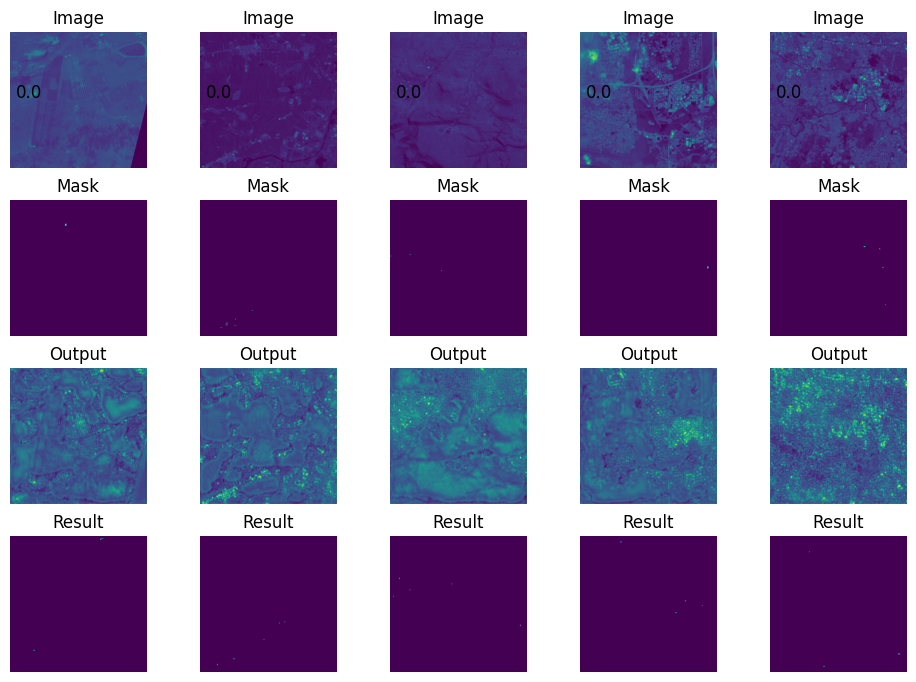

In [131]:
plt.figure(figsize=(12, 8)) # figure size 조정
num = 5
for i, (score, image, mask, output) in enumerate(miss[:num]):
    image = image[0].cpu().detach().numpy()
    image = np.reshape(image, (256, 256))
    mask = np.reshape(mask[0], (256, 256))
    output = np.reshape(output[0], (256, 256))
    
    low = np.quantile(output, 0.9999)
    result = np.where(output >  low, 1, 0) # 임계값 처리
    
    plt.subplot(4, num, i+1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    plt.text(10, 124, score, color='black', fontsize=12, wrap=True)
    
    plt.subplot(4, num, i+num+1)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis('off')
    
    plt.subplot(4, num, i+2*num+1)
    plt.imshow(output)
    plt.title("Output")
    plt.axis('off')
    
    plt.subplot(4, num, i+3*num+1)
    plt.imshow(result)
    plt.title("Result")
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1) # subplot의 크기 조정
plt.show()

In [115]:
# calculate_miou(result,mask)
calculate_iou(mask == 1, result == 1)

0.0

In [69]:
np.where(mask==1)

(array([63, 64, 64, 65, 65, 66]), array([227, 227, 228, 227, 228, 228]))

In [70]:
np.where(result==1)

(array([63, 64, 64, 65, 65, 66, 83]),
 array([227, 227, 228, 228, 229, 228, 218]))

In [27]:
mask.shape

(256, 256, 1)